Data set is taken from here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/12379

In [320]:
# Import all the libraries used in the notebook
import pandas as pd
from matplotlib import pyplot as plt
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import scale
%matplotlib inline
import hdbscan
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint

In [321]:
# read tab file of voting records (1948 - 2017)
df_votes = pd.read_csv('~/Documents/Capstone-UN/UNVotes1-72.tab',sep='\t')

In [322]:
# filter df for only voting members
df_votes = df_votes[df_votes.member == 1]

In [323]:
# Dropping country and countryname. Using ccode as country key
df_votes_year = df_votes.drop(['Country', 'Countryname'], axis=1) 

In [324]:
# Set a DF to only yes and no votes (0 nd 3)
df_votes_year_binary = df_votes_year[(df_votes_year.vote <= 1) | (df_votes_year.vote == 3)]


In [325]:
# Turn 1 = yes and 3 = no into 0 = no and 1 = yes
df_votes_year_binary.vote = df_votes_year_binary.vote.replace(to_replace=3, value=0, inplace=False, limit=None, regex=False, method='pad', axis=None)


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [326]:
# drop session column and set equal to new df
df_year_features = df_votes_year_binary.drop(['session'], axis=1)

In [327]:
# Vote multiplied by res to create a new v_res column that gives the resolution number if 
# There was a yes vote.  This will be used later to create dummy columns
df_year_features['v_res'] = df_year_features['rcid']*df_year_features['vote']

In [328]:
#I'm creating a df that has one record for every UN nation so that it can be merged with our output later
df_name_index = pd.DataFrame(df_votes.groupby(['ccode', 'Countryname','Country'])['Countryname'].count())
df_name_index['count'] = df_name_index.Countryname
df_name_index = df_name_index.drop([ 'Countryname','count'], axis=1)
df_name_index.reset_index(inplace=True)

# Create function to create DFs for multiple years

In [385]:
# read in descr file
df_descriptions = pd.read_csv('~/documents/UN-Capstone/Dscription.csv',skipinitialspace=True)

In [386]:
year = 1995
year2 = 1995

df_output_years = df_year_features[df_year_features['year'].between(year, year2, inclusive=True)]
df_output_years = pd.concat([df_output_years,pd.get_dummies(df_output_years.v_res, prefix='res_')], axis = 1)
try:
    df_output_years = df_output_years.drop(['year','rcid','member','v_res','vote', 'res__0.0'], axis=1)
except:
    pass 
df_output_years = df_output_years.set_index('ccode')
df_output_years = df_output_years.groupby('ccode').sum()

df_output_years_unchnged = df_output_years

df_output_years.columns


Index(['res__3873.0', 'res__3875.0', 'res__3876.0', 'res__3877.0',
       'res__3878.0', 'res__3879.0', 'res__3880.0', 'res__3881.0',
       'res__3883.0', 'res__3884.0', 'res__3885.0', 'res__3886.0',
       'res__3887.0', 'res__3888.0', 'res__3889.0', 'res__3890.0',
       'res__3891.0', 'res__3892.0', 'res__3893.0', 'res__3894.0',
       'res__3895.0', 'res__3896.0', 'res__3897.0', 'res__3898.0',
       'res__3899.0', 'res__3900.0', 'res__3901.0', 'res__3902.0',
       'res__3903.0', 'res__3904.0', 'res__3905.0', 'res__3906.0',
       'res__3907.0', 'res__3908.0', 'res__3909.0', 'res__3910.0',
       'res__3911.0', 'res__3917.0', 'res__3920.0', 'res__3921.0',
       'res__3922.0', 'res__3923.0', 'res__3924.0', 'res__3925.0',
       'res__3926.0', 'res__3927.0', 'res__3928.0', 'res__3929.0',
       'res__3930.0', 'res__3931.0', 'res__3932.0', 'res__3933.0',
       'res__3934.0', 'res__3935.0', 'res__3936.0', 'res__3937.0',
       'res__3938.0', 'res__3939.0', 'res__3940.0', 'res__3941

In [399]:
year = 1995
year2 = 1995

df_output_years = df_year_features[df_year_features['year'].between(year, year2, inclusive=True)]
df_output_years = pd.concat([df_output_years,pd.get_dummies(df_output_years.v_res, prefix='res_')], axis = 1)
try:
    df_output_years = df_output_years.drop(['year','rcid','member','v_res','vote', 'res__0.0'], axis=1)
except:
    pass 
df_output_years = df_output_years.set_index('ccode')
df_output_years = df_output_years.groupby('ccode').sum()
df_output_years_unchnged = df_output_years

#HDBSCAN:
hdbscn = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 5, 
           gen_min_span_tree = True)
hdbscn.fit(df_output_years)
hdbscn_labels = hdbscn.labels_
hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)

#df_output_year = create_year_df(year);
df_output_years['cluster'] = hdbscn.labels_
df_output_years.reset_index(inplace=True)
df_output_years = pd.merge(df_output_years, df_name_index, on='ccode')

#Create cluster lists
cluster0_list = df_output_years[df_output_years.cluster == 0]['Countryname'].tolist()
cluster1_list = df_output_years[df_output_years.cluster == 1]['Countryname'].tolist()
cluster2_list = df_output_years[df_output_years.cluster == 2]['Countryname'].tolist()
cluster_Outlier_list = df_output_years[df_output_years.cluster == -1]['Countryname'].tolist()

 
print(df_output_years_unchnged.shape)
print('Silhouette Coefficient: %0.6f' % metrics.silhouette_score(df_output_years_unchnged, hdbscn_labels))
print('Estimated number of clusters: %d' % hdbscn_n_clusters_)
#print(df_name_index).head()


(177, 81)
Silhouette Coefficient: -0.055926
Estimated number of clusters: 2


In [388]:
cluster_Outlier_list

['United States of America',
 'Bahamas',
 'Dominica',
 'Grenada',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Antigua and Barbuda',
 'Saint Kitts and Nevis',
 'Guatemala',
 'El Salvador',
 'Nicaragua',
 'Costa Rica',
 'Paraguay',
 'Argentina',
 'United Kingdom of Great Britain and Northern Ireland',
 'Belgium',
 'France',
 'Monaco',
 'Liechtenstein',
 'San Marino',
 'Bosnia and Herzegovina',
 'Greece',
 'Russian Federation',
 'Latvia',
 'Ukraine',
 'Belarus',
 'Georgia',
 'Azerbaijan',
 'Guinea Bissau',
 'Equatorial Guinea',
 'Gambia (Islamic Republic of the)',
 'Sierra Leone',
 'Nigeria',
 'Congo',
 'Democratic Republic of the Congo',
 'United Republic of Tanzania',
 'Burundi',
 'Rwanda',
 'Eritrea',
 'Angola',
 'Mozambique',
 'Namibia',
 'Lesotho',
 'Swaziland',
 'Madagascar',
 'Seychelles',
 'Iran (Islamic Republic of)',
 'Israel',
 'Yemen',
 'Afghanistan',
 'Turkmenistan',
 'Tajikistan',
 'Kyrgyzstan',
 'Uzbekistan',
 "Democratic People's Republic of Korea",
 'Republic o

In [ ]:
def output_all(year):
    #HDBSCAN:
    hdbscn = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 10, 
               gen_min_span_tree = True)
    hdbscn.fit(frames.get(year))
    hdbscn_labels = hdbscn.labels_
    hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)
    
    df_output_year = create_year_df(year);
    df_output_year['cluster'] = hdbscn.labels_
    df_output_year.reset_index(inplace=True)
    df_output_year = pd.merge(df_output_year, df_name_index, on='ccode')
    
    #Create cluster lists
    cluster0_list = df_output_year[df_output_year.cluster == 0]['Countryname'].tolist()
    cluster1_list = df_output_year[df_output_year.cluster == 1]['Countryname'].tolist()
    cluster2_list = df_output_year[df_output_year.cluster == 2]['Countryname'].tolist()
    cluster_Outlier_list = df_output_year[df_output_year.cluster == -1]['Countryname'].tolist()

    #PCA:
    df_PCA = df_output_year.drop(['Countryname','Country'], axis=1)
    df_features = df_PCA
    X = df_PCA
    X = X.set_index('ccode')
    pca = PCA()
    pca = pca.fit(X)
    Z = pca.transform(X)
    features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
    
    Z = pd.DataFrame(Z, columns=features_pca)
    X.reset_index(inplace=True)
    X = X[['ccode','cluster']]
    
    X = X.join(Z, lsuffix='_caller', rsuffix='_other')
    df_PCA = pd.merge(X, df_PCA, on='ccode')
    df_PCA = df_PCA[['ccode','cluster_x',"PC1","PC2"]] 
    
    # Rolling Out PC1 components:
    PCA_abs = abs((pca.components_))[0]
    df_features = df_features.set_index(['ccode','cluster'])
    t = zip(df_features.columns, PCA_abs)
    result_list = list(t)
    df_componenets = pd.DataFrame(result_list)
    df_componenets.columns = ['rcid', 'score']
    df_componenets = df_componenets.sort_values('score',ascending=False)
    df_componenets['rcid'] = df_componenets['rcid'].map(lambda x: x.lstrip('res__'))
    df_componenets['rcid'] = df_componenets['rcid'].astype(float)
  
    df_componenets = pd.merge(df_componenets, df_descriptions, on='rcid')
    df_pca_desc = df_componenets.descr
    df_componenets = df_componenets.drop(['abstain','session','date',
                                          'importantvote','unres','amend',
                                          'para', 'year','Unnamed: 0','descr','me', 'nu','di', 'hr', 'co','ec',], axis=1) #,'short'
    
    pd.set_option('display.max_colwidth',110)
    
    #Plot PCA
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.scatter(Z.iloc[:,0], Z.iloc[:,1],
                       c=df_PCA.cluster_x)
    ax.set_xlabel('principal component 1', fontsize=16)
    ax.set_ylabel('principal component 2', fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
 
    pd.set_option('display.max_colwidth', -1)   
    ax.set_title('PC1 vs PC2\n', fontsize=20)
    print(plt.show())
    
    # print HDBSCAN RESULTS:
    print('Estimated number of clusters: %d' % hdbscn_n_clusters_)
    # print('Homogeneity: %0.6f' % metrics.homogeneity_score(frames.get(year), hdbscn_labels))
    # print('Completeness: %0.6f' % metrics.completeness_score(y, hdbscn_labels))
    print('Silhouette Coefficient: %0.6f' % metrics.silhouette_score(frames.get(year), hdbscn_labels))
    
    print ("\n\n","Cluster 0:",len(cluster0_list),"\n",cluster0_list)
    print ("\n\n","Cluster 1:",len(cluster1_list),"\n",cluster1_list)
    if len(cluster2_list) > 0:
        print ("\n\n","Cluster 2:",len(cluster2_list),"\n",cluster2_list)
    else: ""
    
    print ("\n\n","Outliers:",len(cluster_Outlier_list),"\n",cluster_Outlier_list)
    
    print('\n',df_componenets.head(10))
    return df_pca_desc.head(10)

    
output_all(1967)  

In [189]:
# This function takes a year as an argument and returns a df with 1s and 0s indicating whether each member country
# voted on each resolution proposed in a that year
# def create_year_df(year):
#     df_output_year = df_year_features[df_year_features['year'] == year]
#     df_output_year = pd.concat([df_output_year,pd.get_dummies(df_output_year.v_res, prefix='res_')], axis = 1)
#     #print(df_output_year)
#     try:
#         df_output_year = df_output_year.drop(['year','rcid','member','v_res','vote', 'res__0.0'], axis=1)
#     except:
#         pass 
#     df_output_year = df_output_year.set_index('ccode')
#     df_output_year = df_output_year.groupby('ccode').sum()
    
#     return df_output_year
# create_year_df(1948);

In [129]:
# creating dictionary of years and corresponding dataframe names passing aech value from the 
# groups list into the for loop at the bottom of the cell
frames = {}
groups = [1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,  
          1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
          1975, 1976, 1977, 1978, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1986, 1988, 1989,
          1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
          2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
for grp in groups: 
    frames[grp] = create_year_df(grp)  

In [130]:
# Making sure my keys correspond with the groups list created in the last cell
frames.keys()

dict_keys([1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [131]:
# Confirming that the dataframe looks proper
frames.get(1946).head(4)

,res__3.0,res__4.0,res__5.0,res__6.0,res__7.0,res__8.0,res__9.0,res__10.0,res__11.0,res__12.0,...,res__36.0,res__37.0,res__38.0,res__39.0,res__40.0,res__41.0,res__42.0,res__43.0,res__44.0,res__45.0
ccode,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,1,1,1,1,...,0,0,1,0,1,0,0,1,1,1
20,0,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,0,0,1,1,0
40,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,1,1,0
41,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0


In [136]:
# it looks like it fairly frequent that resolutions fall into a category.  I need to see how many resolutions have no cat
# I'll add a column that totals all the others and see how many == 0
print(df_descriptions['isreal_Pal'].value_counts())
print(df_descriptions['nucl_wep'].value_counts())
print(df_descriptions['arms_cont'].value_counts())
print(df_descriptions['colonial'].value_counts())
print(df_descriptions['hmn_rights'].value_counts())
print(df_descriptions['econ_dev'].value_counts())

0    4587
1    1015
Name: isreal_Pal, dtype: int64
0    4876
1     726
Name: nucl_wep, dtype: int64
0    4622
1     980
Name: arms_cont, dtype: int64
0    4662
1     940
Name: colonial, dtype: int64
0    4642
1     960
Name: hmn_rights, dtype: int64
0    4896
1     706
Name: econ_dev, dtype: int64


In [137]:
df_descriptions['code_count'] = df_descriptions[['isreal_Pal', 'nucl_wep',
                                              'arms_cont','colonial',
                                              'hmn_rights','econ_dev']].sum(axis=1)
df_descriptions['code_count'].value_counts()
# It looks like about 1/3 of resolutions have no cat.  Now I need to see if this changes by period.
# It looks like its consistent enough over time that we'll need more variables

1    2528
0    1786
2    1066
3     221
4       1
Name: code_count, dtype: int64

In [151]:
df_descriptions.head(10)


,Unnamed: 0,session,rcid,abstain,yes,no,importantvote,date,unres,amend,...,short,descr,isreal_Pal,nucl_wep,arms_cont,hmn_rights,colonial,econ_dev,year,code_count
0,1,1,3,4,29,18,0,1946-01-01,R/1/66,1.0,...,"AMENDMENTS, RULES OF PROCEDURE",TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...,0,0,0,0,0,0,1946,0
1,2,1,4,8,9,34,0,1946-01-02,R/1/79,0.0,...,SECURITY COUNCIL ELECTIONS,TO ADOPT A USSR PROPOSAL ADJOURNING DEBATE ON ...,0,0,0,0,0,0,1946,0
2,3,1,5,1,28,22,0,1946-01-04,R/1/98,0.0,...,VOTING PROCEDURE,TO ADOPT THE KOREAN PROPOSAL THAT INVALID BALL...,0,0,0,0,0,0,1946,0
3,4,1,6,10,12,27,0,1946-01-04,R/1/107,0.0,...,DECLARATION OF HUMAN RIGHTS,TO ADOPT A CUBAN PROPOSAL (A/3-C) THAT AN ITEM...,0,0,0,1,0,0,1946,1
4,5,1,7,0,25,18,0,1946-01-02,R/1/295,1.0,...,GENERAL ASSEMBLY ELECTIONS,TO ADOPT A 6TH COMMITTEE AMENDMENT (A/14) TO T...,0,0,0,0,0,0,1946,0
5,6,1,8,2,38,1,0,1946-01-05,R/1/297,1.0,...,ECOSOC POWERS,TO ADOPT A SECOND 6TH COMM. AMENDMENT (A/14) T...,0,0,0,0,0,1,1946,1
6,7,1,9,2,45,0,0,1946-02-05,R/1/329,0.0,...,POST-WAR RECONSTRUCTION,TO OPEN THE DISCUSSION ON THE POLISH DRAFT RES...,0,0,0,0,0,0,1946,0
7,8,1,10,0,46,2,0,1946-02-05,R/1/361,1.0,...,"U.N. MEMBERS, RELATIONS WITH SPAIN",TO ADOPT GENERAL COMM. DRAFT RESOLUTION (A/40)...,0,0,0,0,0,0,1946,0
8,9,1,11,0,41,0,0,1946-02-05,R/1/376,0.0,...,TRUSTEESHIP AMENDMENTS,TO ADOPT DRAFT RESOLUTIONS I AND II AS A WHOLE...,0,0,0,0,1,1,1946,2
9,10,1,12,3,21,22,0,1946-02-06,R/1/394,1.0,...,COUNCIL MEMBER TERM LENGTH,TO ADOPT PARAGRAPH (A) OF THE 6TH COMM. DRAFT ...,0,0,0,0,0,0,1946,0


In [139]:
## so far my desc variables for identifying weights are:
## the 6 cats, 
# amend- whether the vote was on an amendment (coded only until 1985)
# para- whether the vote was on a paragraph rather than an entire resolution (coded only until 1985)
# important- Vote identified as important by U.S. State Department report Voting Practices in the United Nations. These
# reports began being issued in session 39.

In [146]:
# I'm going to try and create another few variables. I suppose the same variables can be used to predict egan scores
# as can be used to predict vote passage:
# Do the US and China disagree, Do US and Russia disagree, Do UK and US disagree, Do Russia and China disagree
# I could throw in france and germany for good measure. 
#ccodes: Russia, United States, China, UK, France, Germany

#frames.get(1946)
df_test = frames.get(1946).transpose(copy=True)
df_test

ccode,2,20,40,41,42,70,90,91,92,93,...,651,652,660,670,700,713,750,840,900,920
res__3.0,1,0,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,1,0,0
res__4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
res__5.0,0,0,1,0,0,1,0,1,1,1,...,1,1,1,1,0,1,0,1,1,0
res__6.0,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,1,1,0
res__7.0,0,0,1,1,1,1,0,1,0,1,...,1,1,1,1,0,0,0,0,0,0
res__8.0,0,1,1,0,1,1,1,0,0,0,...,1,1,1,0,0,1,1,1,1,1
res__9.0,1,1,1,1,1,1,0,0,1,0,...,1,1,1,1,0,1,1,1,1,1
res__10.0,1,1,1,1,1,1,1,0,0,0,...,1,1,0,1,0,1,1,0,1,1
res__11.0,1,1,1,0,1,0,0,1,0,0,...,1,1,1,1,0,1,1,1,1,1
res__12.0,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,1,1,1


## Output function

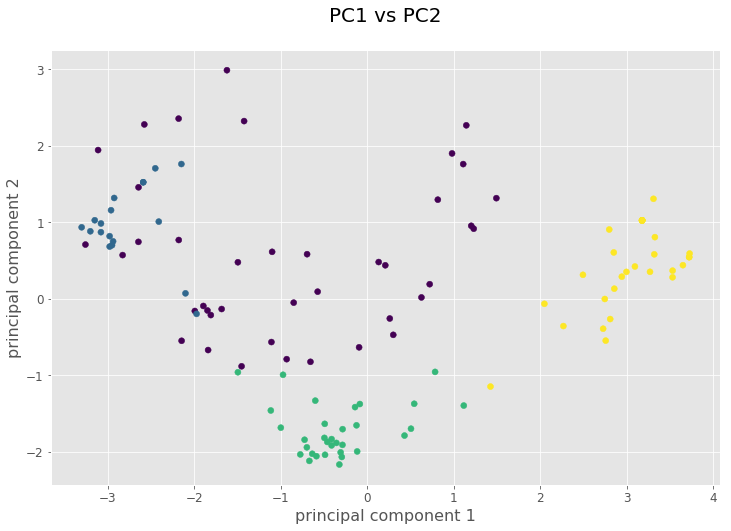

None
Estimated number of clusters: 3
Silhouette Coefficient: 0.184731


 Cluster 0: 18 
 ['United States of America', 'Canada', 'United Kingdom of Great Britain and Northern Ireland', 'Ireland', 'Netherlands', 'Belgium', 'Luxembourg', 'Austria', 'Italy', 'Malta', 'Finland', 'Sweden', 'Norway', 'Denmark', 'Iceland', 'Japan', 'Australia', 'New Zealand']


 Cluster 1: 32 
 ['Dominican Republic', 'Jamaica', 'Trinidad and Tobago', 'Mexico', 'Guatemala', 'Honduras', 'Nicaragua', 'Colombia', 'Venezuela, Bolivarian Republic of', 'Ecuador', 'Brazil', 'Bolivia (Plurinational State of)', 'Paraguay', 'Chile', 'Argentina', 'Uruguay', 'Spain', 'Benin', 'Niger', "Côte D'Ivoire", 'Burkina Faso', 'Sierra Leone', 'Ghana', 'Togo', 'Chad', 'Madagascar', 'Iran (Islamic Republic of)', 'Taiwan, Province of China', 'Nepal', 'Thailand', "Lao People's Democratic Republic", 'Philippines']


 Cluster 2: 32 
 ['Cuba', 'Poland', 'Hungary', 'Czechoslovakia', 'Yugoslavia', 'Bulgaria', 'Romania', 'Russian Federation',

0    TO ADOPT OPERATIVE PARAG. 2 OF THE U.S.S.R. DRAFT RESOL. (A/L.519) ON PALESTINE, WHICH PARAGRAPH DEMANDS THAT ISRAEL IMMEDIATELY AND UNCONDITIONALLY WITHDRAW ALL ITS FORCES BEHIND LINES STIPULATED IN THE GENERAL ARMISTICE AGREEMENTS (EXISTING B  
1    TO ADOPT THE AMENDMENT (A/L. 542) TO DRAFT RESOL. (A/7008) ON \INTERNATIONAL YEAR FOR HUMAN RIGHTS\\, WHICH AMENDMENT DELETES THE WORD \\"OTHER\\" BETWEEN THE WORDS \\"INVITES\\" AND \\"NON-GOVERNMENTAL ORGANIZATIONS\\" IN OPERATIVE PARAG. 11.\""
2    TO ADOPT THE AMENDMENT (A/L. 542) TO DRAFT RESOL. (A/7008) ON \INTERNATIONAL YEAR FOR HUMAN RIGHTS\\, WHICH AMENDMENT DELETES OPERATIVE PARAG.10.\""                                                                                                  
3    TO ADOPT AMENDMENT (A/L. 542) TO DRAFT RESOL. (A/7008) ON \INTERNATIONAL YEAR FOR HUMAN RIGHTS\\, WHICH AMENDMENT REPLACES CERTAIN WORDS IN OPERATIVE PARAGRAPH 11.\""                                                                         

In [43]:
# This function forms the basis of the project's finished product and contrains code for prosessing the 
# UN vote DFs and; running through HDBSCAN to create lusters, printing the number of clusters, printing
# a silhouette score, printing a list of countries in each cluster, running the df through PCA analysis, 
# outputting a visualization of clusters based on principle components 1 and 2, and listing the resultions
# which caused the groupings (top 5 contriubuting the most to vaiance)

def output_all(year):
    #HDBSCAN:
    hdbscn = hdbscan.HDBSCAN(min_cluster_size = 15, min_samples = 10, 
               gen_min_span_tree = True)
    hdbscn.fit(frames.get(year))
    hdbscn_labels = hdbscn.labels_
    hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)
    
    df_output_year = create_year_df(year);
    df_output_year['cluster'] = hdbscn.labels_
    df_output_year.reset_index(inplace=True)
    df_output_year = pd.merge(df_output_year, df_name_index, on='ccode')
    
    #Create cluster lists
    cluster0_list = df_output_year[df_output_year.cluster == 0]['Countryname'].tolist()
    cluster1_list = df_output_year[df_output_year.cluster == 1]['Countryname'].tolist()
    cluster2_list = df_output_year[df_output_year.cluster == 2]['Countryname'].tolist()
    cluster_Outlier_list = df_output_year[df_output_year.cluster == -1]['Countryname'].tolist()

    #PCA:
    df_PCA = df_output_year.drop(['Countryname','Country'], axis=1)
    df_features = df_PCA
    X = df_PCA
    X = X.set_index('ccode')
    pca = PCA()
    pca = pca.fit(X)
    Z = pca.transform(X)
    features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
    
    Z = pd.DataFrame(Z, columns=features_pca)
    X.reset_index(inplace=True)
    X = X[['ccode','cluster']]
    
    X = X.join(Z, lsuffix='_caller', rsuffix='_other')
    df_PCA = pd.merge(X, df_PCA, on='ccode')
    df_PCA = df_PCA[['ccode','cluster_x',"PC1","PC2"]] 
    
    # Rolling Out PC1 components:
    PCA_abs = abs((pca.components_))[0]
    df_features = df_features.set_index(['ccode','cluster'])
    t = zip(df_features.columns, PCA_abs)
    result_list = list(t)
    df_componenets = pd.DataFrame(result_list)
    df_componenets.columns = ['rcid', 'score']
    df_componenets = df_componenets.sort_values('score',ascending=False)
    df_componenets['rcid'] = df_componenets['rcid'].map(lambda x: x.lstrip('res__'))
    df_componenets['rcid'] = df_componenets['rcid'].astype(float)
  
    df_componenets = pd.merge(df_componenets, df_descriptions, on='rcid')
    df_pca_desc = df_componenets.descr
    df_componenets = df_componenets.drop(['abstain','session','date',
                                          'importantvote','unres','amend',
                                          'para', 'year','Unnamed: 0','descr','me', 'nu','di', 'hr', 'co','ec',], axis=1) #,'short'
    
    pd.set_option('display.max_colwidth',110)
    
    #Plot PCA
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.scatter(Z.iloc[:,0], Z.iloc[:,1],
                       c=df_PCA.cluster_x)
    ax.set_xlabel('principal component 1', fontsize=16)
    ax.set_ylabel('principal component 2', fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
 
    pd.set_option('display.max_colwidth', -1)   
    ax.set_title('PC1 vs PC2\n', fontsize=20)
    print(plt.show())
    
    # print HDBSCAN RESULTS:
    print('Estimated number of clusters: %d' % hdbscn_n_clusters_)
    # print('Homogeneity: %0.6f' % metrics.homogeneity_score(frames.get(year), hdbscn_labels))
    # print('Completeness: %0.6f' % metrics.completeness_score(y, hdbscn_labels))
    print('Silhouette Coefficient: %0.6f' % metrics.silhouette_score(frames.get(year), hdbscn_labels))
    
    print ("\n\n","Cluster 0:",len(cluster0_list),"\n",cluster0_list)
    print ("\n\n","Cluster 1:",len(cluster1_list),"\n",cluster1_list)
    if len(cluster2_list) > 0:
        print ("\n\n","Cluster 2:",len(cluster2_list),"\n",cluster2_list)
    else: ""
    
    print ("\n\n","Outliers:",len(cluster_Outlier_list),"\n",cluster_Outlier_list)
    
    print('\n',df_componenets.head(10))
    return df_pca_desc.head(10)

    
output_all(1967)  

In [44]:
# When looking at the above output I was able to do this: I noticed that in 1960 a majority of the resolutions
# having the greatest weighting from PCA analysis related to resolution related to the Repulic of the Congo.
# I can see that the clusters there appears to be a a split along traditional cold war lines.  If I googel Congo
# 1960: https://en.wikipedia.org/wiki/Congo_Crisis#United_Nations_escalation_and_the_end_of_the_Katangese_secession
# "Congo Crisis" comes up on the top.  The page says that there "August 1960, Central Intelligence Agency (CIA) 
# agents in the region reported to their agency that "Congo [is] experiencing [a] classic communist ... takeover" 
# and warned that the Congo might follow the same path as Cuba.". So, not perfect, but the results seem useful.

In [47]:
interact(output_all, year=widgets.IntSlider(min=1946,max=2017,step=1))

interactive(children=(IntSlider(value=1946, description='year', max=2017, min=1946), Output()), _dom_classes=('widget-interact',))

<function __main__.output_all>

In [274]:
df_descriptions[df_descriptions.rcid == 677 ].descr



708    TO ADOPT 4TH COMM. DRAFT RESOLUTION II (A/4672) REQUESTING BELGIUM TO REVOKE ITS SUSPENSION OF THE POWERS ...
Name: descr, dtype: object

# Write Up

Write Up
This project seeks to understand how countries cooperate or form groupings during United Nations General Assembly.  More specifically, how do their voting records, each year, reflect attitudes toward major international crises and political decision making.  What resolutions are most significant to forming these groupings and how can they help us understand the major historical events of the time.

In order to do so, I looked at the entire General Assembly voting record of all countries from 1946 - 2017. I've chosen not to include the voting records of the UN Security Council because of the limit number of members and voting history.

## Data Acquisition
The data comes from the UN API portal here: http://data.un.org/Host.aspx?Content=API maintained by the United Nations. The specific data I used is organized by Erik Voeten from Harvard Univerity an is available here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/12379. The data includes a large amount of information not needed for the analysis.  In total there are 1,099,156 rows including votes on 5,598 resolutions.
   
## Data Cleaning and Feature Engineering
The data is very clean.  It doesn't include nulls, missing data or any important typos.  The was some cleaning and feature engineering due to unnecessary data as well as a need to reformat and engineer the data for use in modeling.

I first removed all records for non-member country voting records (typically coded as "present"). These states, when coded as non-members, are included in the data set for consistency.  They had to be removed because they were not able to vote as a non-member and may not have even been nations at the time of voting.  I only wanted to look at 'yes' and 'no, votes so all other vote types were dropped.  With only yes and no votes remaining I changed the coding of yes and no votes to 1 and 0 for processing.  

I then create a library of years and built a function to create a dataframe for each year of the approx. 70 years of voting history so that years could be analyzed separately.  

For PCA the dataframes for each year are joined with a dataset of resolution descriptions and merged with voting records so that the specifics of each resolution could be visualized if they were important.

   
## Modeling Process

I used HDBSCAN as the basis for this project.  -means and DBSCAN were evaluated, but HDBSCAN performed best in terms of both performance (measure by silhouette score) and in automatically selected the number of  clusters.  I chose a minimum cluster size of 10.  Some years still create errors due to  failure to cluster with that year's information, but min clusters of 10 was the size that created the most consistent clustering over the period the data was collected (1946 - 2017).  The model was found to be successful when it repeatedly produced clusters consistent with historical literature and created a low number of errors when applied to each year.

I then passed my data through a Principal Component Analysis (PCA).  This proved useful for feature selection and visualization. PCA served two purposes in this project.  First, it allows the clusters to be visualized in 2D.  Once the model was constructed it proved successful right away.  It shows the size and the arrangement of the yearly clustering.  There are some limitations to the visualization however.  You can see closeness in the clusters, but its difficult to interpret this.  It also doesn't show the geographic layout.  At the moment I'm not able to show which country in the visualization is which.

Second, I'm using the PCA analysis to find which resolutions were weighted most heavily.  In other words which resolutions contributed the most variance and therefore would have the greatest effect on clusters in a given year.  This was possible because virtually all the variance was placed on component 1 once the analysis was run.

   
## Any future deployment strategies, additions of data, or modeling techniques you have yet to try

There's a quite a few useful strategies and techniques that can be employed in the future. I would consider include abstaining votes in the model (weighted by a factor based on literature review).  It would also be useful to categorize resolutions based on NLP Topic Modeling. Topics could be used to to better understand clustering around certain issues. I could conceivably rerun models based on specific topic areas, and possibly run clusters over 5-year periods to see long term topic-based trends.

It would also be very useful to visualize clusters geographically by placing them on a world map
Finally, I would also like to update the output function so that, as the number of member nations increases, the minimum cluster size increases in proportion
